In [1]:
import os
import pickle

import numpy as np
import pandas as pd
import math
from natsort import natsorted

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.patches import Ellipse
from matplotlib.path import Path
from matplotlib import colors
from matplotlib.colors import ListedColormap

from PIL import Image, ImageDraw

from tifffile import imread

from umap import UMAP
import hdbscan
from joblib import Memory

import napari

from skimage.util import img_as_float
from skimage.color import gray2rgb

In [2]:
# INITIALLY RUN THIS SCRIPT IN IPYTHON IF ROI SELECTIONS ARE TO BE UPDATED

In [3]:
def categorical_cmap(numUniqueSamples, numCatagories, cmap='tab10', continuous=False):

    numSubcatagories = math.ceil(numUniqueSamples/numCatagories)

    if numCatagories > plt.get_cmap(cmap).N:
        raise ValueError('Too many categories for colormap.')
    if continuous:
        ccolors = plt.get_cmap(cmap)(np.linspace(0, 1, numCatagories))
    else:
        ccolors = plt.get_cmap(cmap)(np.arange(numCatagories, dtype=int))
        # rearrange hue order to taste
        cd = {
            'B': 0, 'O': 1, 'G': 2, 'R': 3, 'Pu': 4,
            'Br': 5, 'Pi': 6, 'Gr': 7, 'Y': 8, 'Cy': 9,
            }
        myorder = [
            cd['B'], cd['O'], cd['G'], cd['Pu'], cd['Y'],
            cd['R'], cd['Cy'], cd['Br'], cd['Gr'], cd['Pi']
            ]
        ccolors = [ccolors[i] for i in myorder]

        # use Okabe and Ito color-safe palette for first 6 colors
        # ccolors[0] = np.array([0.91, 0.29, 0.235]) #E84A3C
        # ccolors[1] = np.array([0.18, 0.16, 0.15]) #2E2926
        ccolors[0] = np.array([0.0, 0.447, 0.698, 1.0])  # blue
        ccolors[1] = np.array([0.902, 0.624, 0.0, 1.0])  # orange
        ccolors[2] = np.array([0.0, 0.620, 0.451, 1.0])  # bluish green
        ccolors[3] = np.array([0.8, 0.475, 0.655, 1.0])  # reddish purple
        ccolors[4] = np.array([0.941, 0.894, 0.259, 1.0])  # yellow
        ccolors[5] = np.array([0.835, 0.369, 0.0, 1.0])  # vermillion

    cols = np.zeros((numCatagories * numSubcatagories, 3))
    for i, c in enumerate(ccolors):
        chsv = colors.rgb_to_hsv(c[:3])
        arhsv = np.tile(chsv, numSubcatagories).reshape(numSubcatagories, 3)
        arhsv[:, 1] = np.linspace(chsv[1], 0.25, numSubcatagories)
        arhsv[:, 2] = np.linspace(chsv[2], 1, numSubcatagories)
        rgb = colors.hsv_to_rgb(arhsv)
        cols[i * numSubcatagories:(i + 1) * numSubcatagories, :] = rgb
    cmap = colors.ListedColormap(cols)

    # trim colors if necessary
    if len(cmap.colors) > numUniqueSamples:
        trim = len(cmap.colors) - numUniqueSamples
        cmap_colors = cmap.colors[:-trim]
        cmap = colors.ListedColormap(cmap_colors, name='from_list', N=None)

    return cmap

In [4]:
# create save directory
save_dir = '/Users/greg/Dropbox (HMS)/Baker_QC_2021/script_output/optical_artifact_sardana'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [5]:
# read NON-BACKGROUND SUBTRACTED SARDANA CSV!
data = pd.read_csv('/Volumes/My Book/QC_challenge/csv/unmicst-WD-76845-097_cellRing.csv')

# read markers.csv
markers = pd.read_csv('/Volumes/My Book/cylinter_input/sardana-097/markers.csv')

# log-transform columns to be used in clustering
clustering_cols = [
    i for i in list(markers['marker_name']) if not
    any(x in i for x in ['Hoechst', 'AF488', 'AF555', 'AF647', 'A488', 'A555', 'A647',
                   'Ki67_570', 'Ki67_488', 'anti_NaKATPase'])
        ]
data = data[['CellID', 'X_centroid', 'Y_centroid'] + clustering_cols].copy()
log_data = np.log10(data[clustering_cols] + 0.00001)
data.update(log_data)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


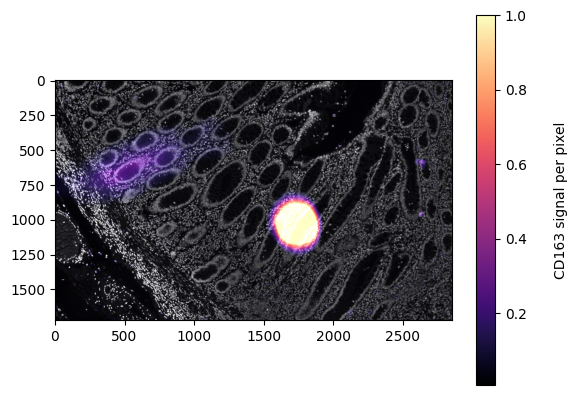

In [6]:
# define image crop window
row_min = 11460
row_max = 13180
col_min = 15400
col_max = 18250

# select single cells within cropped image
data_crop = data[(data['X_centroid'].between(col_min, col_max)) & (data['Y_centroid'].between(row_min, row_max))].copy()

# transform x, y coordinates of cells within cropped image
data_crop['X_centroid'] = data_crop['X_centroid']-col_min
data_crop['Y_centroid'] = data_crop['Y_centroid']-row_min

# read SARDANA segmentation outlines and crop
seg = imread(f'/Volumes/My Book/cylinter_input/sardana-097/seg/WD-76845-097.ome.tif', key=0)
seg_crop = seg[row_min:row_max, col_min:col_max]

# read DNA1 image of SARDANA image, crop, and convert to RGB
dna = imread(f'/Volumes/My Book/cylinter_input/sardana-097/tif/WD-76845-097.ome.tif', key=0)
dna_float = img_as_float(dna)
dna_float -= dna_float.min()
dna_float /= dna_float.max()
dna_crop = dna_float[row_min:row_max, col_min:col_max]
dna_crop_rgb = gray2rgb(dna_crop)

# read CD163 channel of SARDANA image, crop, and convert to RGB with colormap
cd163 = imread(f'/Volumes/My Book/cylinter_input/sardana-097/tif/WD-76845-097.ome.tif', key=25)
cd163_float = img_as_float(cd163)
cd163_float -= cd163_float.min()
cd163_float /= cd163_float.max()
cd163_crop = cd163_float[row_min:row_max, col_min:col_max].copy()
bottom_cutoff = 0.05 
top_cutoff = 0.4
cd163_crop_rgb = np.clip(cd163_crop, bottom_cutoff, top_cutoff)
cd163_crop_rgb = (cd163_crop_rgb - np.min(cd163_crop_rgb)) / (np.max(cd163_crop_rgb) - np.min(cd163_crop_rgb))  # normalize 0-1

cd163_crop_rgb = plt.cm.magma(cd163_crop_rgb) # converts to RGBA
cd163_crop_rgb = cd163_crop_rgb[:, :, 0:3]  # drop alpha dimension

dna_crop_rgb/= 1.0  # modify DNA intensity if needed and combine DNA and CD163 cropped images
dna_crop_rgb += cd163_crop_rgb

# plot image overlay
plt.imshow(dna_crop_rgb, cmap='magma')
plt.grid(False)
plt.savefig(os.path.join(save_dir, 'raster.png'), dpi=600)
cbar = plt.colorbar()
cbar.set_alpha(1.0)
cbar.set_label('CD163 signal per pixel', labelpad=20, rotation=90)
# plt.title('SARDANA')
# cbar.draw_all()
plt.savefig(os.path.join(save_dir, 'vector.pdf'))
plt.show()
plt.close('all')

In [7]:
# open SARDANA image in Napari to select ROIs (if not already done) 

# read saved polygon vertices (if ROIs have been darawn already) 
if os.path.exists(os.path.join(save_dir, f'polygon_dict_WD-76845-097.pkl')):
    
    f = open(os.path.join(save_dir, f'polygon_dict_WD-76845-097.pkl'), 'rb')
    polygon_dict = pickle.load(f)
    
    shapes = [polygon_dict[i][0] for
              i in range(0, len(polygon_dict.keys()))]
    polygons = [polygon_dict[i][1] for
              i in range(0, len(polygon_dict.keys()))]

else:
    viewer = napari.view_image(dna_crop, opacity=0.5, rgb=False, name='DNA1')

    viewer.add_image(
        seg_crop, rgb=False, blending='additive',
        opacity=0.5, colormap='green', visible=False,
        name='segmentation'
        )

    viewer.add_image(
        cd163_crop, rgb=False, blending='additive',
        colormap='magma', visible=True,
        name='CD163'
        )
    
    selection_layer = viewer.add_shapes(
    shape_type='polygon',
    ndim=2,
    face_color=[1.0, 1.0, 1.0, 0.2],
    edge_color=[0.0, 0.66, 1.0, 1.0],
    edge_width=10.0,
    name='ROI(s)'
    )
    
    # view existing ROIs in Napari
    # selection_layer = viewer.add_shapes(
    #     data=polygons,
    #     shape_type=shapes,
    #     ndim=2,
    #     face_color=[0.0, 1.0, 0.0, 0.0],  # [1.0, 1.0, 1.0, 0.2]
    #     edge_color=[0.0, 1.0, 0.0, 1.0], # [0.0, 0.66, 1.0, 1.0]
    #     edge_width=20.0,
    #     name='ROI(s)')
    
    napari.run()
    ################### RUN ABOVE CODE FIRST, THEN RUN REMAINDER ONCE ROIs HAVE BEEN CURATED 
    
    polygon_dict = {}
    
    # store lists vertices per sample as a dictionary
    for e, (shape_type, roi) in enumerate(zip(
      selection_layer.shape_type, selection_layer.data)):
        polygon_dict[e] = (shape_type, roi)

    f = open(os.path.join(save_dir, 'polygon_dict_WD-76845-097.pkl'), 'wb')
    pickle.dump(polygon_dict, f)
    f.close()

In [8]:
def triangulate_ellipse(corners, num_segments=100):
    
    # from Napari GitHub: napari/napari/layers/shapes/_shapes_utils.py 
    
    """Determines the triangulation of a path. The resulting `offsets` can
    multiplied by a `width` scalar and be added to the resulting `centers`
    to generate the vertices of the triangles for the triangulation, i.e.
    `vertices = centers + width*offsets`. Using the `centers` and `offsets`
    representation thus allows for the computed triangulation to be
    independent of the line width.
    Parameters
    ----------
    corners : np.ndarray
        4xD array of four bounding corners of the ellipse. The ellipse will
        still be computed properly even if the rectangle determined by the
        corners is not axis aligned
    num_segments : int
        Integer determining the number of segments to use when triangulating
        the ellipse
    Returns
    -------
    vertices : np.ndarray
        Mx2 array coordinates of vertices for triangulating an ellipse.
        Includes the center vertex of the ellipse, followed by `num_segments`
        vertices around the boundary of the ellipse
    triangles : np.ndarray
        Px2 array of the indices of the vertices for the triangles of the
        triangulation. Has length given by `num_segments`
    """
    if not corners.shape[0] == 4:
        raise ValueError(
            trans._(
                "Data shape does not match expected `[4, D]` shape specifying corners for the ellipse",
                deferred=True,
            )
        )

    center = corners.mean(axis=0)
    adjusted = corners - center

    vec = adjusted[1] - adjusted[0]
    len_vec = np.linalg.norm(vec)
    if len_vec > 0:
        # rotate to be axis aligned
        norm_vec = vec / len_vec
        if corners.shape[1] == 2:
            transform = np.array(
                [[norm_vec[0], -norm_vec[1]], [norm_vec[1], norm_vec[0]]]
            )
        else:
            transform = np.array(
                [
                    [0, 0],
                    [norm_vec[0], -norm_vec[1]],
                    [norm_vec[1], norm_vec[0]],
                ]
            )
        adjusted = np.matmul(adjusted, transform)
    else:
        transform = np.eye(corners.shape[1])

    radii = abs(adjusted[0])
    vertices = np.zeros((num_segments + 1, 2), dtype=np.float32)
    theta = np.linspace(0, np.deg2rad(360), num_segments)
    vertices[1:, 0] = radii[0] * np.cos(theta)
    vertices[1:, 1] = radii[1] * np.sin(theta)

    if len_vec > 0:
        # rotate back
        vertices = np.matmul(vertices, transform.T)

    # Shift back to center
    vertices = vertices + center

    triangles = np.array([[0, i + 1, i + 2] for i in range(num_segments)])
    triangles[-1, 2] = 1

    return vertices, triangles

In [9]:
# isolate SARDANA data within ROI bounds
roi_data = data_crop[['X_centroid', 'Y_centroid', 'CellID']].astype(int)
roi_data['tuple'] = list(zip(roi_data['X_centroid'], roi_data['Y_centroid']))

cell_ids_dict = {}

for key, (shape_type, verts) in polygon_dict.items():

    selection_verts = np.round(verts).astype(int)
    
    # create pillow image to convert into boolean mask
    img = Image.new('L', (dna_crop.shape[1], dna_crop.shape[0]))

    if shape_type == 'ellipse':
        
        vertices, triangles = triangulate_ellipse(selection_verts)
        
        # flip 2-tuple coordinates returned by
        # triangulate_ellipse() to draw image mask
        vertices = [tuple(reversed(tuple(i))) for i in vertices]

        # update pillow image with polygon
        ImageDraw.Draw(img).polygon(
            vertices, outline=1, fill=1
            )
    
    else:
        vertices = list(tuple(
            zip(selection_verts[:, 1],
                selection_verts[:, 0])
            ))

        # update pillow image with polygon
        ImageDraw.Draw(img).polygon(
            vertices, outline=1, fill=1
            )
    
    # convert pillow image into boolean numpy array
    mask = np.array(img, dtype=bool)
    
    # use numpy fancy indexing to get centroids
    # where boolean mask is True
    xs, ys = zip(*roi_data['tuple'])
    inter = mask[ys, xs]
 
    cell_ids = set(roi_data['CellID'][inter])
 
    cell_ids_dict[key] = cell_ids

In [10]:
# perform embedding
print('Performing UMAP embedding...')
clus_data = data_crop.copy()
clus_data = clus_data.sample(frac=1.0, random_state=5)
embedding = UMAP(random_state=4, n_neighbors=25, min_dist=0.1, repulsion_strength=5.0).fit_transform(clus_data[clustering_cols])
clus_data['emb1'] = embedding[:, 0]
clus_data['emb2'] = embedding[:, 1]

Performing UMAP embedding...


/Users/greg/venvs/cylinter_test/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


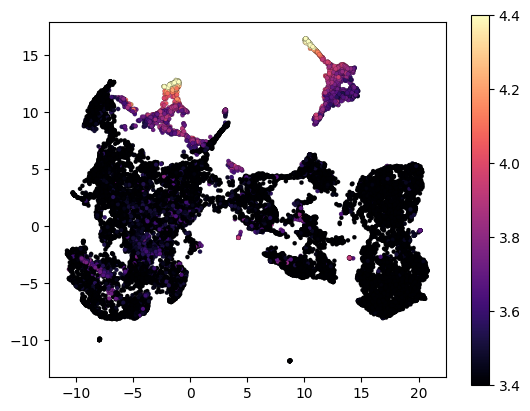

In [11]:
# plot clustering
lw = 0.1
fig, ax = plt.subplots()
sc = ax.scatter(clus_data['emb1'], clus_data['emb2'], c=clus_data['CD163_488'], cmap='magma', s=9.5, ec='k', lw=lw, alpha=1.0, vmin=3.4, vmax=4.4)
plt.colorbar(sc)
ax.set_aspect('equal')
plt.savefig(os.path.join(save_dir, 'cmap.png'), dpi=1000)
plt.show()
plt.close('all')

22629 cells


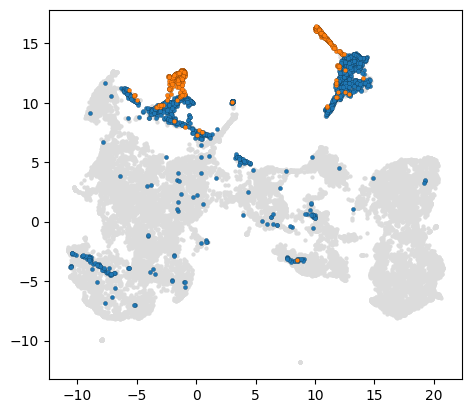

In [12]:
combo_ids = set()
for k, v, in cell_ids_dict.items():

    if k == 0:
        c1 = 'tab:blue'
        in_roi1 = clus_data[clus_data['CellID'].isin(v)]
    elif k == 1:
        c2 = 'tab:orange'
        in_roi2 = clus_data[clus_data['CellID'].isin(v)]

    combo_ids.update(cell_ids_dict[k])
   
    
out_roi = clus_data[~clus_data['CellID'].isin(combo_ids)]

print(f'{len(clus_data)} cells')

fig, ax = plt.subplots() 
ax.scatter(out_roi['emb1'], out_roi['emb2'], c='gainsboro', s=9.5, ec='k', lw=0.0, alpha=1.0)
ax.scatter(in_roi1['emb1'], in_roi1['emb2'], c=c1, s=9.5, ec='k', lw=lw, alpha=1.0)
ax.scatter(in_roi2['emb1'], in_roi2['emb2'], c=c2, s=9.5, ec='k', lw=lw, alpha=1.0)
ax.set_aspect('equal')
plt.savefig(os.path.join(save_dir, 'gate.png'), dpi=1000)
plt.show()
plt.close('all')

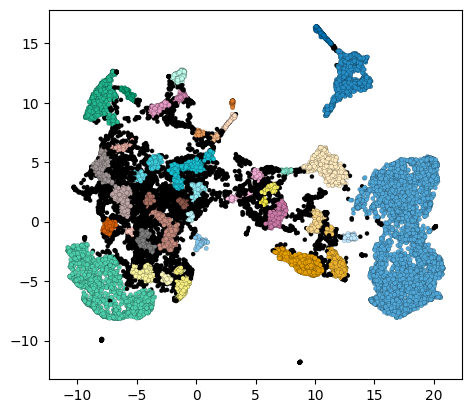

In [22]:
# cluster with HDBSCAN 
clustering = hdbscan.HDBSCAN(min_cluster_size=51).fit(clus_data[['emb1', 'emb2']])
clus_data['cluster'] = clustering.labels_

# generate categorical cmap for clusters
cmap = categorical_cmap(
    numUniqueSamples=len(clus_data['cluster'].unique()),
    numCatagories=10, cmap='tab10', continuous=False)

cmap = ListedColormap(
    np.insert(
        arr=cmap.colors, obj=0,
        values=[0, 0, 0], axis=0)
        )

# trim cmap to # unique samples
trim = (
    len(cmap.colors) - len(
        clus_data['cluster'].unique())
    )
cmap = ListedColormap(
    cmap.colors[:-trim]
    )

sample_dict = dict(
    zip(
        natsorted(
            clus_data['cluster'].unique()),
        list(range(len(clus_data['cluster']
             .unique()))))
        )

c = [sample_dict[i] for i
     in clus_data['cluster']]

fig, ax = plt.subplots()
ax.scatter(clus_data['emb1'], clus_data['emb2'], c=c, cmap=cmap, s=9.5, ec=[0.0, 0.0, 0.0], lw=lw, alpha=1.0)
ax.set_aspect('equal')
plt.savefig(os.path.join(save_dir, 'clustering.png'), dpi=1000)
plt.show()
plt.close('all')